# Common Test I. Multi-Class Classification

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

## Strategy

Initially I tried using the common Image classification models like ResNet34, ResNet101 etc with and without pretraining but the classification accuracy was around 33% which is only as good as a random guess. So I tried using few Vision Transformers and Equivariant Neural Networks and Equivariant NNs worked better so I trained the final model using it. 

In Hindsight, Traditional CNNs are only translationaly invariant and require multiple filters to detect features at different orientations. But Equivariant NNs are rotationally invariant and can detect features at any orientation. Since the given dataset is a 2D lensing images, it is important to detect features at any orientation making Equivariant NNs a better choice. 

## Importing Library

In [1]:
!pip install e2cnn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from e2cnn import gspaces
from e2cnn import gspaces, nn as e2nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Data

In [3]:
base_dir = '../datasets/common-test/'
train_folder = base_dir + 'train'
val_folder = base_dir + 'val'

train_df = pd.DataFrame(columns = ['path', 'label'])
val_df = pd.DataFrame(columns = ['path', 'label'])

label_map = {'no':0, 'sphere':1, 'vort':2}
val_label_map = {0:'no', 1:'sphere', 2:'vort'}

for i in label_map.keys():
    entries = [os.path.join(train_folder, i, j) for j in os.listdir(os.path.join(train_folder, i))]
    temp_df = pd.DataFrame({'path':entries, 'label':i})
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

for i in label_map.keys():
    entries = [os.path.join(val_folder, i, j) for j in os.listdir(os.path.join(val_folder, i))]
    temp_df = pd.DataFrame({'path':entries, 'label':i})
    val_df = pd.concat([val_df, temp_df], ignore_index=True)

In [4]:
trainset_split = train_df["label"].value_counts()
print(f"Train Data Split:\n{trainset_split}")

Train Data Split:
no        10000
sphere    10000
vort      10000
Name: label, dtype: int64


In [5]:
valset_split = val_df["label"].value_counts()
print(f"Train Data Split:\n{valset_split}")

Train Data Split:
no        2500
sphere    2500
vort      2500
Name: label, dtype: int64


In [6]:
class Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        img = np.load(img_path, allow_pickle=True)[0].astype('float32')
        img = 255 * (img / img.max())
        img = Image.fromarray(img.astype('uint8')).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]['label']
        label = label_map[label]
        
        return img, label

In [7]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomRotation(180),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = Dataset(train_df, transform=train_transforms)
val_dataset = Dataset(val_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

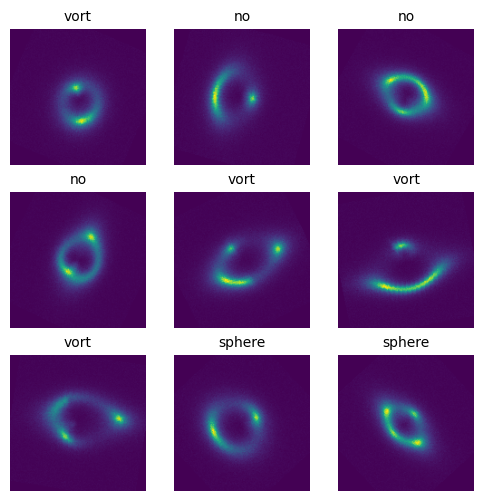

In [8]:
def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*4 + j]
            label = labels[i*4 + j].item()
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = [k for k, v in class_map.items() if v == label][0]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, label_map)

## Defining Model

The base model for this test was taken from [e2cnn library examples](https://github.com/QUVA-Lab/e2cnn/blob/master/examples/model.ipynb) and was modified accordingly to give the best results for this dataset.

In [13]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=3):
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees(2*pi/8), modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=8)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = e2nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # Unlike CNNs, we choose the output type of the convolutional layer to be a feature feilds
        # that are equivariant under the group C8 instead of normal feature maps.
        out_type = e2nn.FieldType(self.r2_act, 12*[self.r2_act.regular_repr])
        
        # convolution 1
        # the first covolution layer outputs 12 regular feature fields of C8 as denoted by the out_type
        self.block1 = e2nn.SequentialModule(
            e2nn.MaskModule(in_type, 150, margin=1),
            e2nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type   
        
        # convolution 2
        # the second covolution layer outputs 24 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block2 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )

        # pointwise average pooling is used instead of max pooling or average pooling
        # to preserve the rotational symmetry of the feature fields
        self.pool1 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        in_type = self.block2.out_type

        # convolution 3
        # the third covolution layer outputs 24 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block3 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        in_type = self.block3.out_type

        # convolution 4
        # the fourth covolution layer outputs 48 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block4 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = e2nn.SequentialModule(
            e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        in_type = self.block4.out_type

        # convolution 5
        # the fifth covolution layer outputs 48 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block5 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )
        
        in_type = self.block5.out_type

        # convolution 6
        # the sixth covolution layer outputs 32 regular feature fields of C8
        out_type = e2nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr])
        self.block6 = e2nn.SequentialModule(
            e2nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            e2nn.InnerBatchNorm(out_type),
            e2nn.ReLU(out_type, inplace=True)
        )

        self.pool3 = e2nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        # group pooling provides a way to aggregate information from all the feature fields,
        # while preserving the rotational symmetry of the feature fields
        self.gpool = e2nn.GroupPooling(out_type)
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(12800, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):

        x = e2nn.GeometricTensor(input, self.input_type)
        x = self.block1(x)
        x = self.block2(x)

        x = self.pool1(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.pool2(x)
        x = self.block5(x)
        x = self.block6(x)

        x = self.pool3(x)
        x = self.gpool(x)

        x = x.tensor
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

## Hyper-parameters and Training

In [11]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, valloader):

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(valloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            val_acc.append(acc)
            val_losses.append(running_val_loss / len(valloader))

        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), '../models/common-test-model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_acc[-1]:.3f}\n")

    return train_losses, train_acc, val_losses, val_acc, best_acc

In [12]:
model = C8SteerableCNN(n_classes=3).to(device)

epochs = 20
lr = 0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

/opt/conda/lib/python3.7/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [13]:
train_losses, train_acc, val_losses, val_acc, best_acc = train(model, epochs, optimizer, loss_function, scheduler, device, train_loader, val_loader)

Epoch: 1


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.63it/s]


Train Loss: 1.109, Train Acc: 0.338, Val Loss: 1.099, Val Acc: 0.345

Epoch: 2


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.901, Train Acc: 0.536, Val Loss: 0.397, Val Acc: 0.851

Epoch: 3


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.361, Train Acc: 0.864, Val Loss: 0.241, Val Acc: 0.918

Epoch: 4


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.286, Train Acc: 0.895, Val Loss: 0.216, Val Acc: 0.928

Epoch: 5


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.202, Train Acc: 0.928, Val Loss: 0.172, Val Acc: 0.940

Epoch: 6


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.61it/s]


Train Loss: 0.181, Train Acc: 0.937, Val Loss: 0.152, Val Acc: 0.949

Epoch: 7


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.173, Train Acc: 0.938, Val Loss: 0.151, Val Acc: 0.949

Epoch: 8


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.168, Train Acc: 0.941, Val Loss: 0.142, Val Acc: 0.951

Epoch: 9


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.156, Train Acc: 0.946, Val Loss: 0.139, Val Acc: 0.951

Epoch: 10


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.153, Train Acc: 0.947, Val Loss: 0.145, Val Acc: 0.952

Epoch: 11


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.150, Train Acc: 0.948, Val Loss: 0.136, Val Acc: 0.954

Epoch: 12


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.152, Train Acc: 0.947, Val Loss: 0.138, Val Acc: 0.951

Epoch: 13


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.149, Train Acc: 0.947, Val Loss: 0.140, Val Acc: 0.951

Epoch: 14


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.146, Train Acc: 0.949, Val Loss: 0.144, Val Acc: 0.951

Epoch: 15


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.146, Train Acc: 0.949, Val Loss: 0.133, Val Acc: 0.953

Epoch: 16


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.151, Train Acc: 0.948, Val Loss: 0.142, Val Acc: 0.953

Epoch: 17


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.147, Train Acc: 0.948, Val Loss: 0.139, Val Acc: 0.953

Epoch: 18


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.145, Train Acc: 0.949, Val Loss: 0.132, Val Acc: 0.954

Epoch: 19


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.147, Train Acc: 0.947, Val Loss: 0.136, Val Acc: 0.954

Epoch: 20


Test	: 100%|██████████| 235/235 [01:29<00:00,  2.62it/s]


Train Loss: 0.149, Train Acc: 0.948, Val Loss: 0.136, Val Acc: 0.955



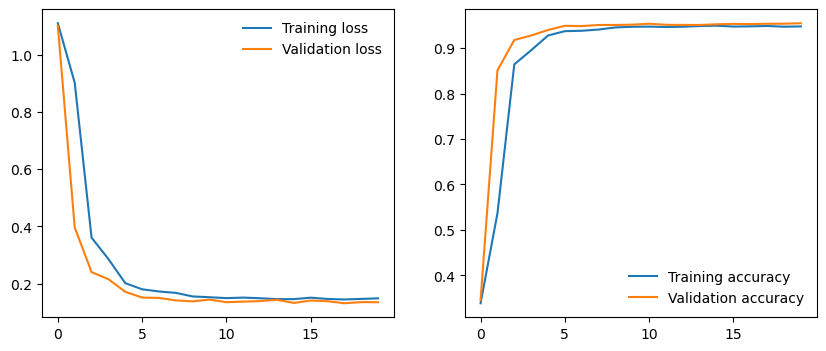

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(frameon=False)

## Testing

The best model is loaded for testing and the results are plotted.

In [15]:
model = C8SteerableCNN(n_classes=3).to(device)
model.load_state_dict(torch.load('../models/common-test-model.pth'))

/home/gautham/.local/lib/python3.10/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


<All keys matched successfully>

In [16]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 235/235 [01:26<00:00,  2.71it/s]


In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class, target_names=label_map.keys()))

              precision    recall  f1-score   support

          no       0.93      0.98      0.96      2500
      sphere       0.96      0.91      0.93      2500
        vort       0.96      0.96      0.96      2500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



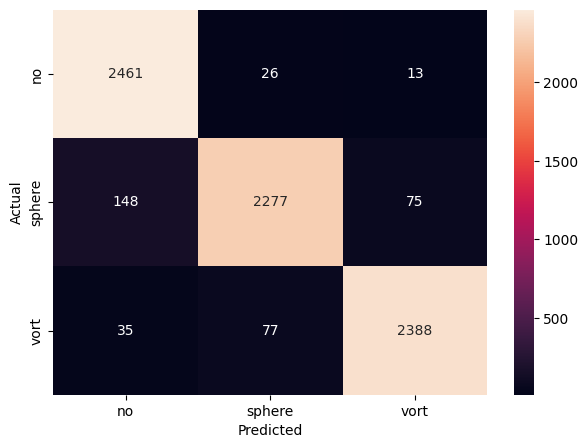

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1, keepdims=True)

y_pred_softmax = softmax(np.array(y_pred_prob))

print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred_softmax, multi_class='ovr')}")

ROC-AUC Score: 0.9926442933333334


no       ROC-AUC: 0.9929987199999999
sphere   ROC-AUC: 0.9828078400000001
vort     ROC-AUC: 0.99349728


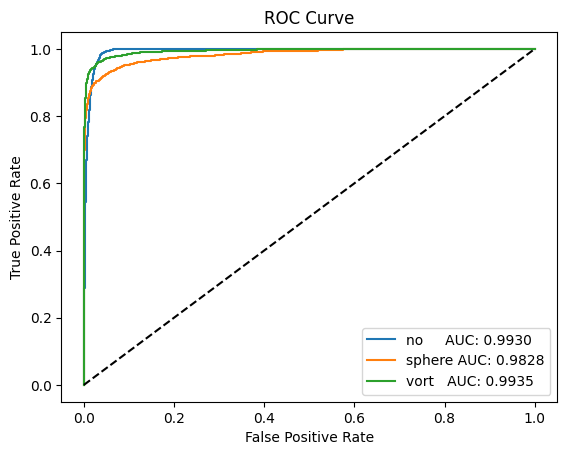

In [20]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(3):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()